In [1]:
import tensorflow as tf
import os

# Root directory of your dataset
dataset_root = "/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits"

# Supported image extensions
image_extensions = ["jpg", "jpeg", "png"]
image_paths = []

# Recursively search for images inside all subfolders (e.g., good/apple/*.jpg)
for ext in image_extensions:
    pattern = os.path.join(dataset_root, "*", "*", f"*.{ext}")
    image_paths.extend(tf.io.gfile.glob(pattern))

# Convert to tensor and shuffle
image_paths = tf.convert_to_tensor(image_paths)
image_paths = tf.random.shuffle(image_paths)

# Print result
print(f" Total images collected: {len(image_paths)}")
print(" Sample image paths:")
for path in image_paths[:5]:
    print(path.numpy().decode())



2025-04-13 10:08:49.321697: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 10:08:49.342912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


 Total images collected: 15819
 Sample image paths:
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Good Quality_Fruits/Pomegranate_Good/IMG20200728142621_27186.jpg
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_144702_23382.jpg
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Good Quality_Fruits/Pomegranate_Good/20190820_154538_26611.jpg
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Good Quality_Fruits/Orange_Good/IMG_20190924_152324.jpg
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Mixed Quality_Fruits/Lemon/IMG20200728191617.jpg


In [2]:
# Step 1: Update the correct folder names used in your dataset
quality_labels = ["Bad Quality_Fruits", "Good Quality_Fruits", "Mixed Quality_Fruits"]
fruit_labels = []

# Step 2: Collect all unique fruit types from paths
for path in image_paths:
    parts = path.numpy().decode().split(os.sep)
    fruit = parts[-2]  # e.g., "apple"
    if fruit not in fruit_labels:
        fruit_labels.append(fruit)

# Step 3: Build maps
quality_to_index = {q: i for i, q in enumerate(quality_labels)}
fruit_to_index = {f: i for i, f in enumerate(sorted(fruit_labels))}

print("Label mappings created.")
print("Quality map:", quality_to_index)
print("Fruit map:", fruit_to_index)

# Step 4: Label extraction function
def extract_labels(path):
    parts = path.numpy().decode().split(os.sep)
    quality = parts[-3]   # folder name: "Bad Quality_Fruits"
    fruit = parts[-2]     # folder name: "apple", "banana", etc.
    return quality_to_index[quality], fruit_to_index[fruit]

# Test it
test_path = image_paths[0]
q_label, f_label = extract_labels(test_path)
print("\nSample label from:")
print(test_path.numpy().decode())
print(f"→ Quality index: {q_label}, Fruit index: {f_label}")


Label mappings created.
Quality map: {'Bad Quality_Fruits': 0, 'Good Quality_Fruits': 1, 'Mixed Quality_Fruits': 2}
Fruit map: {'Apple': 0, 'Apple_Bad': 1, 'Apple_Good': 2, 'Banana': 3, 'Banana_Bad': 4, 'Banana_Good': 5, 'Guava': 6, 'Guava_Bad': 7, 'Guava_Good': 8, 'Lemon': 9, 'Lime_Bad': 10, 'Lime_Good': 11, 'Orange': 12, 'Orange_Bad': 13, 'Orange_Good': 14, 'Pomegranate': 15, 'Pomegranate_Bad': 16, 'Pomegranate_Good': 17}

Sample label from:
/home/aniket/fruit_shelf_life_project/data/FruitNet_Processed_Images/Processed_Images_Fruits/Good Quality_Fruits/Pomegranate_Good/IMG20200728142621_27186.jpg
→ Quality index: 1, Fruit index: 17


In [3]:
import tensorflow as tf

# Step 1: Define label extraction and image preprocessing
def load_and_preprocess_image(path):
    # Read and decode image
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [300, 300])
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)  # scales to [0,1]
    
    # Extract labels
    def get_labels(p):
        parts = p.numpy().decode().split(os.sep)
        quality = parts[-3]
        fruit = parts[-2]
        return quality_to_index[quality], fruit_to_index[fruit]
    
    # Use py_function to call the Python label parser
    quality_label, fruit_label = tf.py_function(
        func=get_labels,
        inp=[path],
        Tout=[tf.int32, tf.int32]
    )
    
    # Set shapes manually
    quality_label.set_shape([])
    fruit_label.set_shape([])
    
    return image, (quality_label, fruit_label)


In [4]:
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.cache()
dataset = dataset.shuffle(1000)
dataset = dataset.batch(32)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)


In [5]:
# Step 3: Check a sample batch
for images, (q_labels, f_labels) in dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Quality labels:", q_labels.numpy()[:5])
    print("Fruit labels:", f_labels.numpy()[:5])


Image batch shape: (32, 300, 300, 3)
Quality labels: [1 1 1 2 1]
Fruit labels: [17 17 17  3 11]


2025-04-13 10:09:05.841471: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-04-13 10:09:05.842769: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
2025-04-13 10:09:15.792569: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range f

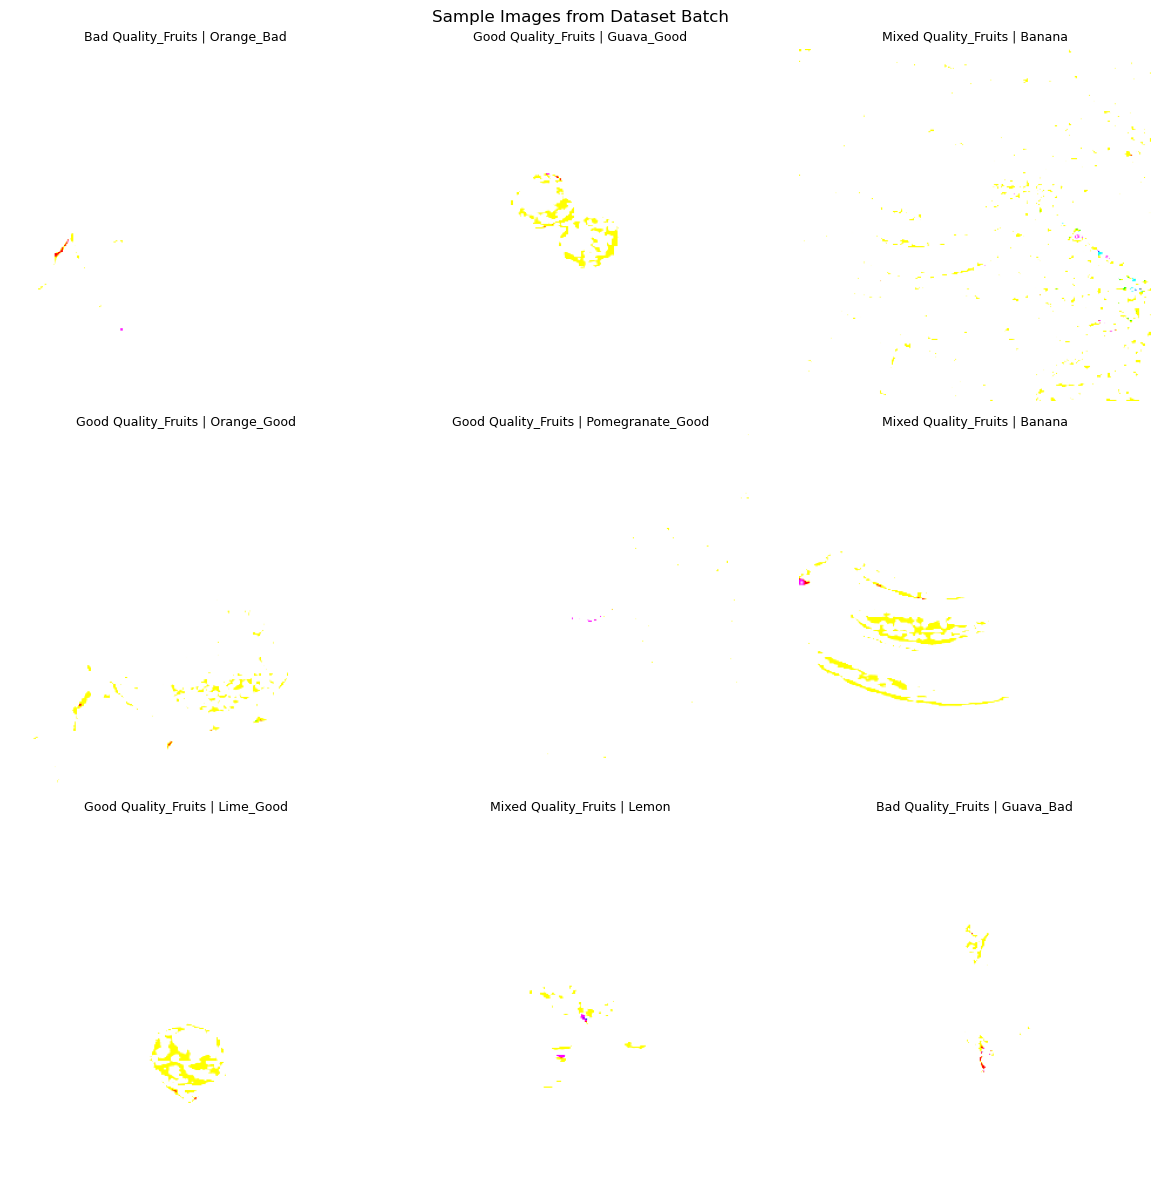

In [6]:
import matplotlib.pyplot as plt

# Reverse mappings to convert label index back to string
index_to_quality = {v: k for k, v in quality_to_index.items()}
index_to_fruit = {v: k for k, v in fruit_to_index.items()}

# Take one batch from the dataset
for images, (q_labels, f_labels) in dataset.take(1):
    plt.figure(figsize=(12, 12))
    
    for i in range(min(9, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        q = index_to_quality[q_labels[i].numpy()]
        f = index_to_fruit[f_labels[i].numpy()]
        plt.title(f"{q} | {f}", fontsize=9)
        plt.axis("off")
    
    plt.suptitle("Sample Images from Dataset Batch")
    plt.tight_layout()
    plt.show()
    break


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# Number of classes for each output
num_quality_classes = len(quality_to_index)   # Should be 3
num_fruit_classes = len(fruit_to_index)        # For example, 18 based on your mapping

# Define the CNN model architecture
def build_model(input_shape=(300, 300, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Convolutional base
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    
    # Branch for quality classification
    quality_output = layers.Dense(num_quality_classes, activation='softmax', name='quality')(x)
    
    # Branch for fruit type classification
    fruit_output = layers.Dense(num_fruit_classes, activation='softmax', name='fruit')(x)
    
    # Create model with two outputs
    model = models.Model(inputs=inputs, outputs=[quality_output, fruit_output])
    
    return model

# Build the model
model = build_model()

# Compile the model with separate loss functions for each output.
# Using categorical_crossentropy if one-hot encoding, or sparse_categorical_crossentropy for integer labels.
# Here, we assume the labels are integer indices.
model.compile(optimizer=optimizers.Adam(),
              loss={'quality': 'sparse_categorical_crossentropy',
                    'fruit': 'sparse_categorical_crossentropy'},
              metrics={'quality': 'accuracy',
                       'fruit': 'accuracy'})

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 300, 300,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 150, 150,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 150, 150,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 75, 75,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 75, 75,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 37, 37,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 175232)    │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │ 44,859,648 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ quality (Dense)     │ (None, 3)         │        771 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fruit (Dense)       │ (None, 18)        │      4,626 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 44,958,293 (171.50 MB)

 Trainable params: 44,958,293 (171.50 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
import tensorflow as tf
import os

# Convert image_paths (which is a tensor) to a numpy list so that we can perform the split
# (Make sure that image_paths is defined as in Part 1)
all_paths = image_paths.numpy().tolist()
total_images = len(all_paths)
print("Total images:", total_images)

# Determine a split index for an 80-20 split (adjust as needed)
split_index = int(0.8 * total_images)

train_paths = all_paths[:split_index]
val_paths = all_paths[split_index:]

# Create TensorFlow datasets from these lists
train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
val_ds = tf.data.Dataset.from_tensor_slices(val_paths)

# Map the load_and_preprocess_image function to both datasets
train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch the training dataset and prefetch for performance
train_ds = train_ds.shuffle(1000).batch(16)
val_ds = val_ds.batch(16)

# Optional: Check one batch from the train dataset
for images, (q_labels, f_labels) in train_ds.take(1):
    print("Train batch images shape:", images.shape)
    print("Train quality labels shape:", q_labels.shape)
    print("Train fruit labels shape:", f_labels.shape)


Total images: 15819
Train batch images shape: (16, 300, 300, 3)
Train quality labels shape: (16,)
Train fruit labels shape: (16,)


2025-04-13 10:09:27.734432: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Train the model for a certain number of epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10  # you can adjust the number of epochs as necessary
)

# After training, you can evaluate the results
print("Training complete. Evaluation on validation dataset:")
model.evaluate(val_ds)


Epoch 1/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 355s 440ms/step - fruit_accuracy: 0.3766 - fruit_loss: 32.1059 - loss: 71.9619 - quality_accuracy: 0.6110 - quality_loss: 39.8560 - val_fruit_accuracy: 0.4143 - val_fruit_loss: 2.0197 - val_loss: 2.7580 - val_quality_accuracy: 0.6334 - val_quality_loss: 0.7394
Epoch 2/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 355s 442ms/step - fruit_accuracy: 0.5328 - fruit_loss: 1.7813 - loss: 2.4589 - quality_accuracy: 0.7126 - quality_loss: 0.6776 - val_fruit_accuracy: 0.7348 - val_fruit_loss: 0.9514 - val_loss: 1.3090 - val_quality_accuracy: 0.8695 - val_quality_loss: 0.3579
Epoch 3/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 355s 442ms/step - fruit_accuracy: 0.7349 - fruit_loss: 0.9549 - loss: 1.3445 - quality_accuracy: 0.8564 - quality_loss: 0.3896 - val_fruit_accuracy: 0.7756 - val_fruit_loss: 0.7777 - val_loss: 1.1008 - val_quality_accuracy: 0.8808 - val_quality_loss: 0.3230
Epoch 4/10
791/791 ━━━━━━━━━━━━━━━━━━━━ 356s 443ms/step - fruit_accuracy: 0.8299 - fruit_loss: 0.5961 -

[1.186645746231079,
 0.3383764922618866,
 0.8552120327949524,
 0.8555625677108765,
 0.9254108667373657]

In [10]:
# Evaluate the model on the validation dataset
evaluation_results = model.evaluate(val_ds, verbose=1)

# The evaluate() method returns overall loss followed by losses and metrics for each output.
# The structure depends on the compile() configuration. For example, if you compiled with:
# loss={'quality': 'sparse_categorical_crossentropy', 'fruit': 'sparse_categorical_crossentropy'}
# metrics={'quality': 'accuracy', 'fruit': 'accuracy'}
#
# then evaluation_results might contain:
# [total_loss, quality_loss, fruit_loss, quality_accuracy, fruit_accuracy]

print("\n--- Evaluation Results on Validation Dataset ---")
print("Total Loss: {:.4f}".format(evaluation_results[0]))
print("Quality Loss: {:.4f}".format(evaluation_results[1]))
print("Fruit Loss: {:.4f}".format(evaluation_results[2]))
print("Quality Accuracy: {:.4f}".format(evaluation_results[3]))
print("Fruit Accuracy: {:.4f}".format(evaluation_results[4]))

# Optionally, generate predictions for a small batch and compare with true labels
for images, (q_labels, f_labels) in val_ds.take(1):
    predictions = model.predict(images)
    predicted_quality = tf.argmax(predictions[0], axis=1)
    predicted_fruit   = tf.argmax(predictions[1], axis=1)
    
    print("\nSample Predictions:")
    print("True Quality Labels: ", q_labels.numpy()[:10])
    print("Predicted Quality:   ", predicted_quality.numpy()[:10])
    print("True Fruit Labels:   ", f_labels.numpy()[:10])
    print("Predicted Fruit:     ", predicted_fruit.numpy()[:10])
    break


198/198 ━━━━━━━━━━━━━━━━━━━━ 22s 106ms/step - fruit_accuracy: 0.8553 - fruit_loss: 0.8284 - loss: 1.1479 - quality_accuracy: 0.9198 - quality_loss: 0.3196

--- Evaluation Results on Validation Dataset ---
Total Loss: 1.1866
Quality Loss: 0.3384
Fruit Loss: 0.8552
Quality Accuracy: 0.8556
Fruit Accuracy: 0.9254
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step

Sample Predictions:
True Quality Labels:  [1 2 0 2 0 1 1 0 0 1]
Predicted Quality:    [1 1 0 2 0 1 1 0 0 1]
True Fruit Labels:    [17  3 10 15 13 17 17 13 16 17]
Predicted Fruit:      [17  8 10 15  7 17 17 13 16 17]
